<a href="https://colab.research.google.com/github/joheras/MusicaCatedralStoDomingoIER/blob/main/Notebooks/SacarM%C3%BAsica/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ice Vision

## Librerías

In [1]:
%%capture
!pip install icevision[all]==0.5.1

In [1]:
from icevision.all import *

In [2]:
%%capture
!unzip Musica.zip

## Funciones

In [3]:
def abrirImagen(path):
  return cv2.imread(str(path))

def imagenDeImagen(img,h=16,w=16):
  plt.figure(figsize = (h,w))
  plt.imshow(img)
  plt.show()

def mostrarImagen(path):
  img=cv2.imread(str(path))
  imagenDeImagen(img)
  return abrirImagen(img)


def imgAnotada(path):
  colores = {'claved':(119, 90, 17), 'claves':(119, 90, 17), 'clavef':(119, 90, 17), 'nota1:8':(150,255,209), 'nota1':(150,255,209), 'nota2':(150,255,209), 'nota4':(150,255,209), 'nota1:2':(150,255,209), 'nota1:4':(150,255,209), 'notae':(150,255,209), 'sos':(242,170,255), 'bem':(242,170,255), 'cal':(242,170,255), 'bec':(242,170,255), 'sil0':(159,142,243), 'sil1':(159,142,243), 'sil2':(159,142,243), 'sil1:2':(159,142,243), 'sil1:4':(159,142,243), '2x4':(173,76,0), '3x4':(173,76,0), '3x2':(173,76,0), '4x4':(173,76,0), '6x8':(173,76,0), 'punt':(0,255,0), 'liga':(40,47,153),'3':(255,0,0),'P2':(255,0,0),'P1':(255,10,40),'mf':(255,10,40),'line':(119,189,255),'check':(35,99,33)}
  img = cv2.imread(str(path))
  n=path.stem+'.json'
  anotacion= json.loads(open(str(path.parent.parent/'annotations'/n)).read())
  for elemento in anotacion:
    x, y, z, w=elemento["box"]
    cv2.rectangle(img, (x, y), (z,w), colores[elemento["label"]], 2)
  return img

def imgEscrita(path):
  colores = {'claved':(119, 90, 17), 'claves':(119, 90, 17), 'clavef':(119, 90, 17), 'nota1:8':(150,255,209), 'nota1':(150,255,209), 'nota2':(150,255,209), 'nota4':(150,255,209), 'nota1:2':(150,255,209), 'nota1:4':(150,255,209), 'notae':(150,255,209), 'sos':(242,170,255), 'bem':(242,170,255), 'cal':(242,170,255), 'bec':(242,170,255), 'sil0':(159,142,243), 'sil1':(159,142,243), 'sil2':(159,142,243), 'sil1:2':(159,142,243), 'sil1:4':(159,142,243), '2x4':(173,76,0), '3x4':(173,76,0), '3x2':(173,76,0), '4x4':(173,76,0), '6x8':(173,76,0), 'punt':(0,255,0), 'liga':(40,47,153),'3':(255,0,0),'P2':(255,10,40),'P1':(255,10,40),'mf':(255,10,40),'line':(119,189,255),'check':(35,99,33)}
  img = cv2.imread(str(path))
  img = imgAnotada(path)
  n=path.stem+'.json'
  anotacion= json.loads(open(str(path.parent.parent/'annotations'/n)).read())
  for elemento in anotacion:
    x, y, z, w=elemento["box"]
    cv2.putText(img, elemento["label"], (int(x+(z-x)/2), w+10), cv2.FONT_HERSHEY_TRIPLEX,0.35, colores[elemento["label"]], 1)
  return img

def pintarPredicciones(num):
  for f in files[0:num]:
    clone=imgAnotada(f)
    txt_pred=open('input/detection-results/'+f.stem+'.txt')
    linea_pred=txt_pred.readline() 
    while linea_pred!='':
      logit,conf,x1,y1,z1,w1=linea_pred.split()
      linea_pred=txt_pred.readline()
      cv2.rectangle(clone, (int(x1), int(y1)), (int(z1),int(w1)), (255, 0, 0), 2)
    imagenDeImagen(clone,31,10)

## Training

In [4]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

In [5]:
AnotacionParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


In [6]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    def __init__(self, path_img,path_anotaciones):
        self.path_img = path_img
        self.path_anotaciones= path_anotaciones

    def __iter__(self):
      with os.scandir(self.path_anotaciones) as ficheros:
        for fichero in ficheros:
          if fichero.name!='.ipynb_checkpoints':
            yield fichero.name

    def imageid(self, o) -> Hashable: #o --> nombre de la anotación
      return o[:o.find('.')]

    def filepath(self, o) -> Union[str, Path]:
      path=Path(f"{o[:o.find('.')]}.jpg")
      return self.path_img / path

    def image_width_height(self, o) -> Tuple[int, int]:
      return get_image_size(self.path_img+'/'+f"{o[:o.find('.')]}.jpg")

    def labels(self, o) -> List[int]:
      d={'background':0,'claved':1, 'claves':2, 'clavef':3, 'nota1':4, 'nota2':5, 'nota4':6, 'nota1:2':7, 'nota1:4':8, 'notae':9, 'sos':10, 'bem':11, 'bec':12, 'sil0':13, 'sil1':14, 'sil2':15, 'sil1:2':16, 'sil1:4':17, '2x4':18, '3x4':19, '4x4':20, '6x8':21, 'punt':22, 'liga':23,'3':24,'line':25,'P2':26, 'nota1:8':27, 'cal':28, '3x2':29,'mf':30,'P1':31,'check':32}
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      label=[]
      for L in anotacion:
        label.append(d[L['label']])
      return label

    def bboxes(self, o) -> List[BBox]:
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      bbox=[]
      for L in anotacion:
        bbox.append(BBox.from_xyxy(L['box'][0],L['box'][1],L['box'][2],L['box'][3]))
      return bbox

In [7]:
files = get_files('/content/pents', folders = ['images'])

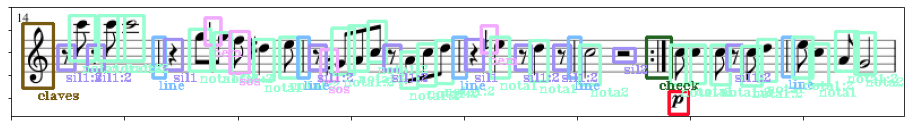

In [10]:
fig, ax = plt.subplots(1,1,figsize=(16,5))
ax.imshow(imgEscrita(files[-3]),cmap=plt.cm.binary)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
plt.show()

In [8]:
len(files)

119

In [11]:
anot=AnotacionParser('pents/images','pents/annotations')

In [13]:
for x in anot:
  print(x)

pent2234.json
pent1293.json
pent1302.json
pent1660.json
pent600.json
pent1343.json
pent974.json
super_mario_theme3.json
pent1933.json
pent1921.json
pent434.json
pent2164.json
pent1721.json
pent1866.json
pent1026.json
pent135.json
pent1211.json
pent1180.json
pent1422.json
pent2072.json
pent1576.json
pent1930.json
pent2277.json
pent479.json
pent291.json
pent1135.json
pent1217.json
pent743.json
super_mario_theme2.json
pent975.json
pent230.json
pent423.json
pent930.json
pent1353.json
pent1533.json
pent2187.json
pent1412.json
pent621.json
pent1291.json
pent1407.json
pent773.json
pent801.json
pent963.json
pent2163.json
pent424.json
pent45.json
pent1092.json
pent219.json
pent1118.json
super_mario_theme9.json
pent508.json
pent734.json
pent1248.json
pent1977.json
pent2286.json
pent1643.json
pent462.json
pent678.json
pent283.json
pent1122.json
super_mario_theme5.json
pent2272.json
pent1950.json
pent1056.json
super_mario_theme1.json
pent1331.json
pent510.json
pent472.json
pent433.json
pent2021.js

In [14]:
anot.imageid('pent1042.jpg')

'pent1042'

In [15]:
anot.imageid('pent1042.json')

'pent1042'

In [16]:
anot.filepath('pent1042.json')

Path('pents/images/pent1042.jpg')

In [17]:
anot.image_width_height('pent1042.json')

(926, 117)

In [18]:
print(anot.labels('super_mario_theme5.json'))

[2, 24, 4, 4, 4, 4, 7, 7, 25, 16, 4, 7, 7, 4, 16, 25, 4, 22, 7, 14, 4, 23, 25, 7, 4, 7, 23, 7, 11, 7, 4, 25, 24, 4, 4, 4, 4, 7, 7, 25, 16, 4, 7, 7, 4, 16, 32, 30, 7, 4, 7, 14, 10, 4]


In [19]:
anot.filepath('pent1042.jpg')

Path('pents/images/pent1042.jpg')

In [20]:
print(anot.bboxes('pent1042.json'))

[<BBox (xmin:15, ymin:22, xmax:52, ymax:73)>, <BBox (xmin:49, ymin:35, xmax:67, ymax:60)>, <BBox (xmin:60, ymin:20, xmax:78, ymax:47)>, <BBox (xmin:95, ymin:35, xmax:118, ymax:81)>, <BBox (xmin:146, ymin:37, xmax:166, ymax:81)>, <BBox (xmin:191, ymin:35, xmax:202, ymax:81)>, <BBox (xmin:210, ymin:37, xmax:262, ymax:81)>, <BBox (xmin:268, ymin:34, xmax:280, ymax:81)>, <BBox (xmin:289, ymin:37, xmax:309, ymax:81)>, <BBox (xmin:337, ymin:28, xmax:367, ymax:76)>, <BBox (xmin:362, ymin:56, xmax:374, ymax:69)>, <BBox (xmin:386, ymin:27, xmax:418, ymax:76)>, <BBox (xmin:417, ymin:34, xmax:429, ymax:81)>, <BBox (xmin:439, ymin:44, xmax:460, ymax:89)>, <BBox (xmin:458, ymin:47, xmax:471, ymax:57)>, <BBox (xmin:485, ymin:38, xmax:507, ymax:80)>, <BBox (xmin:524, ymin:34, xmax:535, ymax:80)>, <BBox (xmin:545, ymin:34, xmax:567, ymax:78)>, <BBox (xmin:565, ymin:36, xmax:578, ymax:46)>, <BBox (xmin:593, ymin:27, xmax:615, ymax:73)>, <BBox (xmin:631, ymin:33, xmax:642, ymax:80)>, <BBox (xmin:653, ym

In [12]:
%%capture
train_rs, valid_rs = anot.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:126


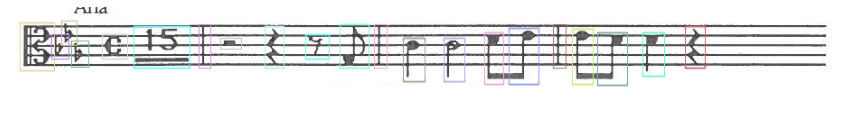

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15, 20))
show_record(train_rs[23], display_label=False,ax=ax)

In [14]:
len(train_rs)/len(files)

0.7983193277310925

## FasterRCNN

In [15]:
class EarlyStoppingMAP(fastai.EarlyStoppingCallback):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., patience=5, reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, patience=patience,reset_on_fit=reset_on_fit)

  def before_fit(self):
    self.wait = 0; super().before_fit()

  def after_epoch(self):
    "Compare the value monitored to its best score and maybe stop training."
    val = self.recorder.values[-1][self.idx]
    if self.comp(val, self.best):
      self.best, self.new_best = val, True
    else:
      self.new_best = False


    if self.new_best:
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        print(f'No improvement since epoch {self.epoch-self.wait}: early stopping')
        raise fastai.CancelFitException()

class SaveModelMAP(fastai.SaveModelCallback):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, with_opt=False,
               reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, fname=fname,every_epoch=every_epoch, with_opt=with_opt,
                     reset_on_fit=reset_on_fit)

  def _save(self, name):
    super()._save(name)

  def after_epoch(self):
    "Compare the value monitored to its best score and save if best."
    if self.every_epoch:
      self._save(f'{self.fname}_{self.epoch}')
    else:  # every improvement
      val = self.recorder.values[-1][self.idx]
      if self.comp(val, self.best):
        self.best, self.new_best = val, True
      else:
        self.new_best = False

      if self.new_best:
        print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
        self._save(f'{self.fname}')

  def after_fit(self, **kwargs):
    "Load the best model."
    super().after_fit(**kwargs)


class ReduceLRMAP(fastai.ReduceLROnPlateau):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., patience=1, factor=10., min_lr=0,
               reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, patience=patience,factor=factor,min_lr=min_lr,
                     reset_on_fit=reset_on_fit)

  def before_fit(self):
    self.wait = 0; super().before_fit()

  def after_epoch(self):
    "Compare the value monitored to its best score and reduce LR by `factor` if no improvement."
    val = self.recorder.values[-1][self.idx]
    if self.comp(val, self.best):
      self.best, self.new_best = val, True
    else:
      self.new_best = False

    if self.new_best:
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        old_lr = self.opt.hypers[-1]['lr']
        for h in self.opt.hypers: h['lr'] = max(h['lr'] / self.factor, self.min_lr)
        self.wait = 0
        if self.opt.hypers[-1]["lr"] < old_lr:
          print(f'Epoch {self.epoch}: reducing lr to {self.opt.hypers[-1]["lr"]}')


def compareM(x1,x2):
  if isinstance(x1,dict):
    x1=float(x1['mAP'])
  if isinstance(x2,dict):
    x2=float(x2['mAP'])
  return np.greater(x1,x2)

In [16]:
model = faster_rcnn.model(num_classes=33)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [17]:
presize = 926
size = 926

In [18]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize,shift_scale_rotate=None,crop_fn=None, horizontal_flip=None, pad=None), tfms.A.Normalize()])

In [19]:
train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

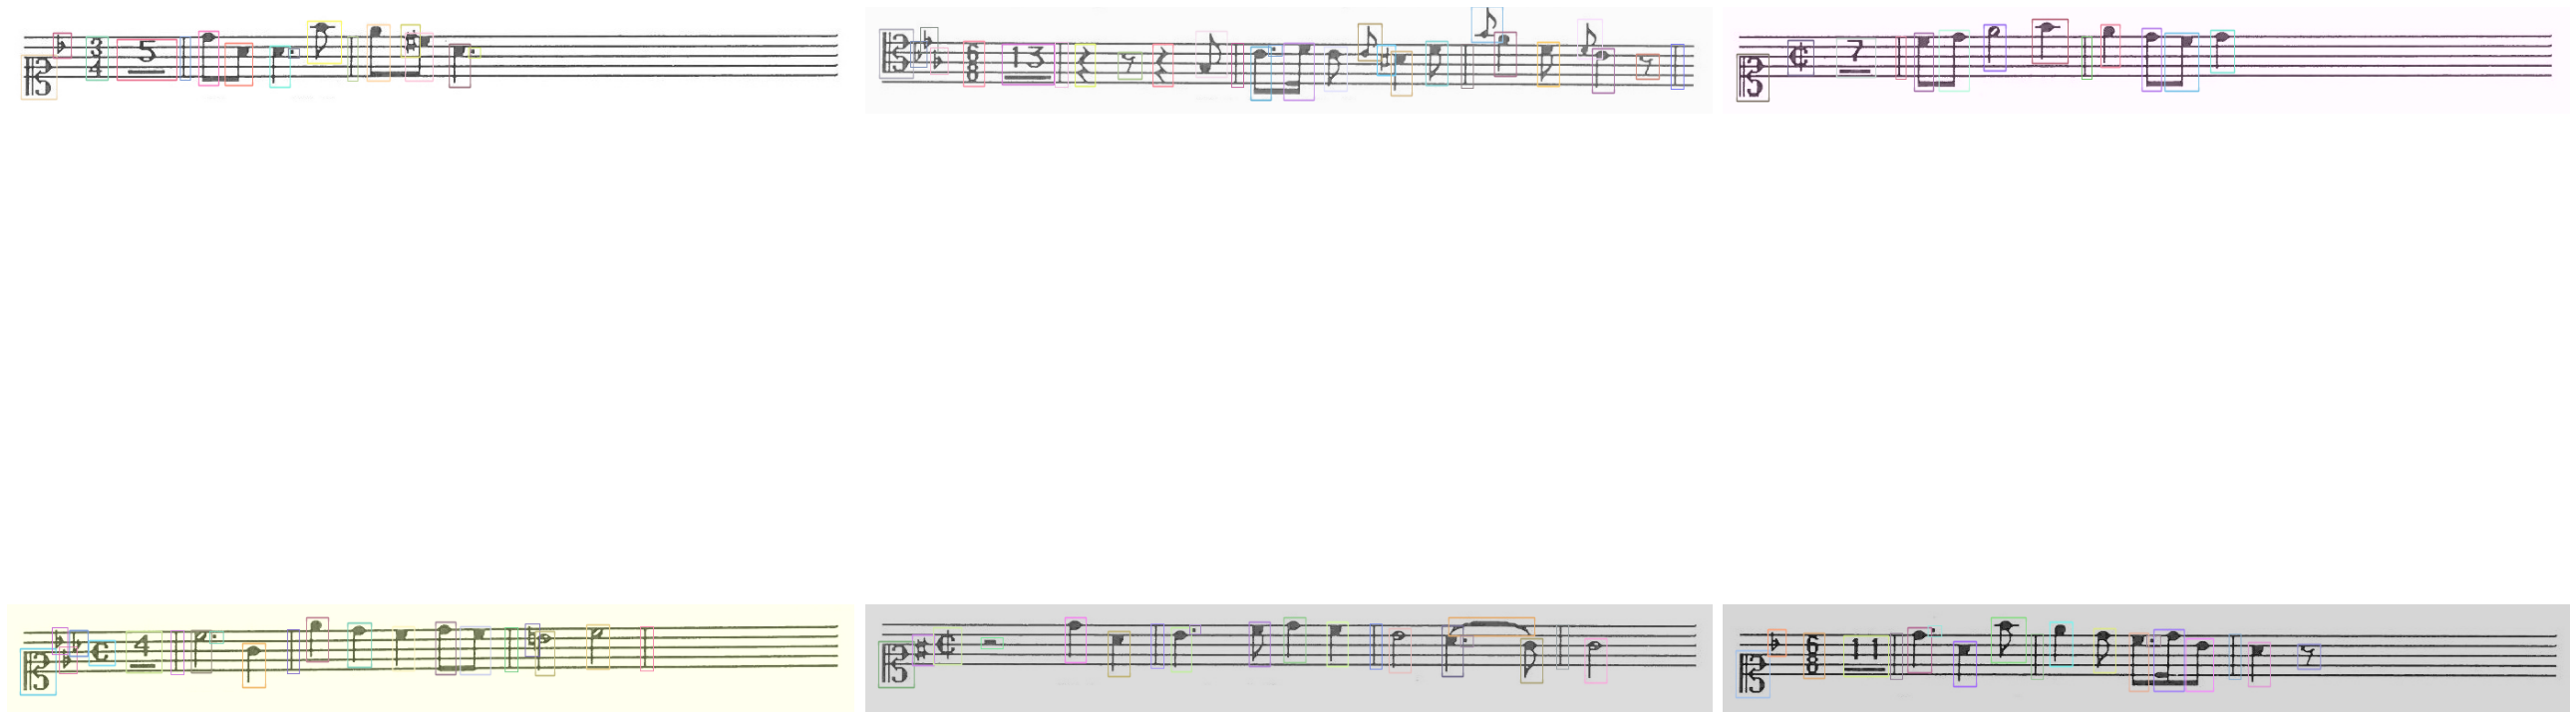

In [20]:
samples = [train_ds[i] for i in range(6)]
show_samples(samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False, show=True)

In [21]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [22]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [23]:
saveM=SaveModelMAP(monitor='COCOMetric',fname='FasterRCMM',comp=compareM)
lrReduce=ReduceLRMAP(monitor='COCOMetric',patience=3, factor=10.0, min_lr=0,comp=compareM)
early=EarlyStoppingMAP(monitor='COCOMetric',patience=5,comp=compareM)

In [24]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=[saveM,lrReduce,early])

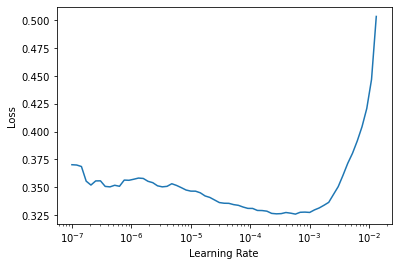

In [46]:
print(learn.recorder.metrics)
(min_lr,step)=learn.lr_find(show_plot=True)

In [47]:
learn.fine_tune(150, lr_min=min_lr, lr_step=step, freeze_epoch=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.452778,0.866662,0.438556,00:14


Better model found at epoch 0 with COCOMetric value: 0.43855631004071427.


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,COCOMetric,time
0,0.486953,0.601629,0.569968,00:17
1,0.431611,0.588563,0.630394,00:17
2,0.398768,0.594054,0.611039,00:17
3,0.373241,0.552193,0.622011,00:17
4,0.353212,0.557284,0.626947,00:17
5,0.336755,0.567849,0.628388,00:17
6,0.323177,0.575054,0.632692,00:17
7,0.311572,0.558674,0.641150,00:17
8,0.301157,0.542702,0.639184,00:17
9,0.291021,0.565912,0.640966,00:17


Better model found at epoch 0 with COCOMetric value: 0.5699680364873807.
Better model found at epoch 1 with COCOMetric value: 0.6303936766149733.
Epoch 4: reducing lr to 2.225565968455989e-05
Better model found at epoch 6 with COCOMetric value: 0.632691600981369.
Better model found at epoch 7 with COCOMetric value: 0.6411498936349603.
Better model found at epoch 10 with COCOMetric value: 0.6430532609650609.
Epoch 13: reducing lr to 3.7247952155374454e-05
No improvement since epoch 10: early stopping


In [48]:
torch.save(model.state_dict(),'mejor.pth')

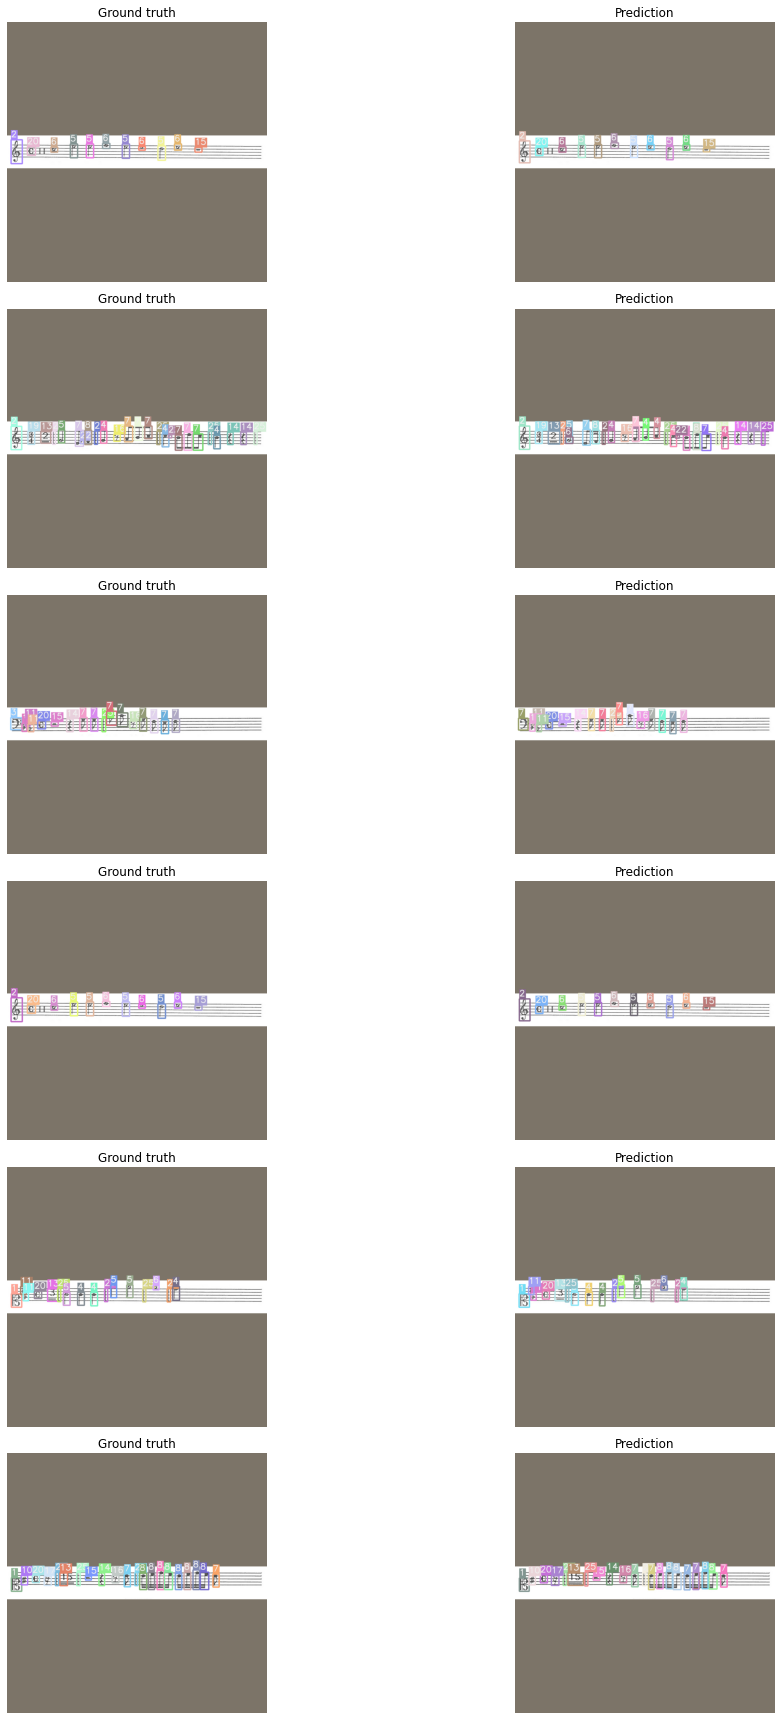

In [49]:
faster_rcnn.show_results(model, valid_ds)

## Inferencia

In [50]:
state_dict = torch.load('mejor.pth')
model = faster_rcnn.model(num_classes=33)

In [51]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [52]:
test1=cv2.imread('/content/prueba.png') # Esta foto está sacada de la web
test2=cv2.imread('/content/prueba2.png') # Esta foto está sacada de la web
test3=cv2.imread('/content/pents/images/pent1211.jpg')

In [53]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=600), tfms.A.Normalize()])
infer_ds = Dataset.from_images([test1,test2,test3], infer_tfms)
infer_dl = faster_rcnn.infer_dl(infer_ds, batch_size=1)
samples, preds = faster_rcnn.predict_dl(model=model, infer_dl=infer_dl)

  0%|          | 0/3 [00:00<?, ?it/s]

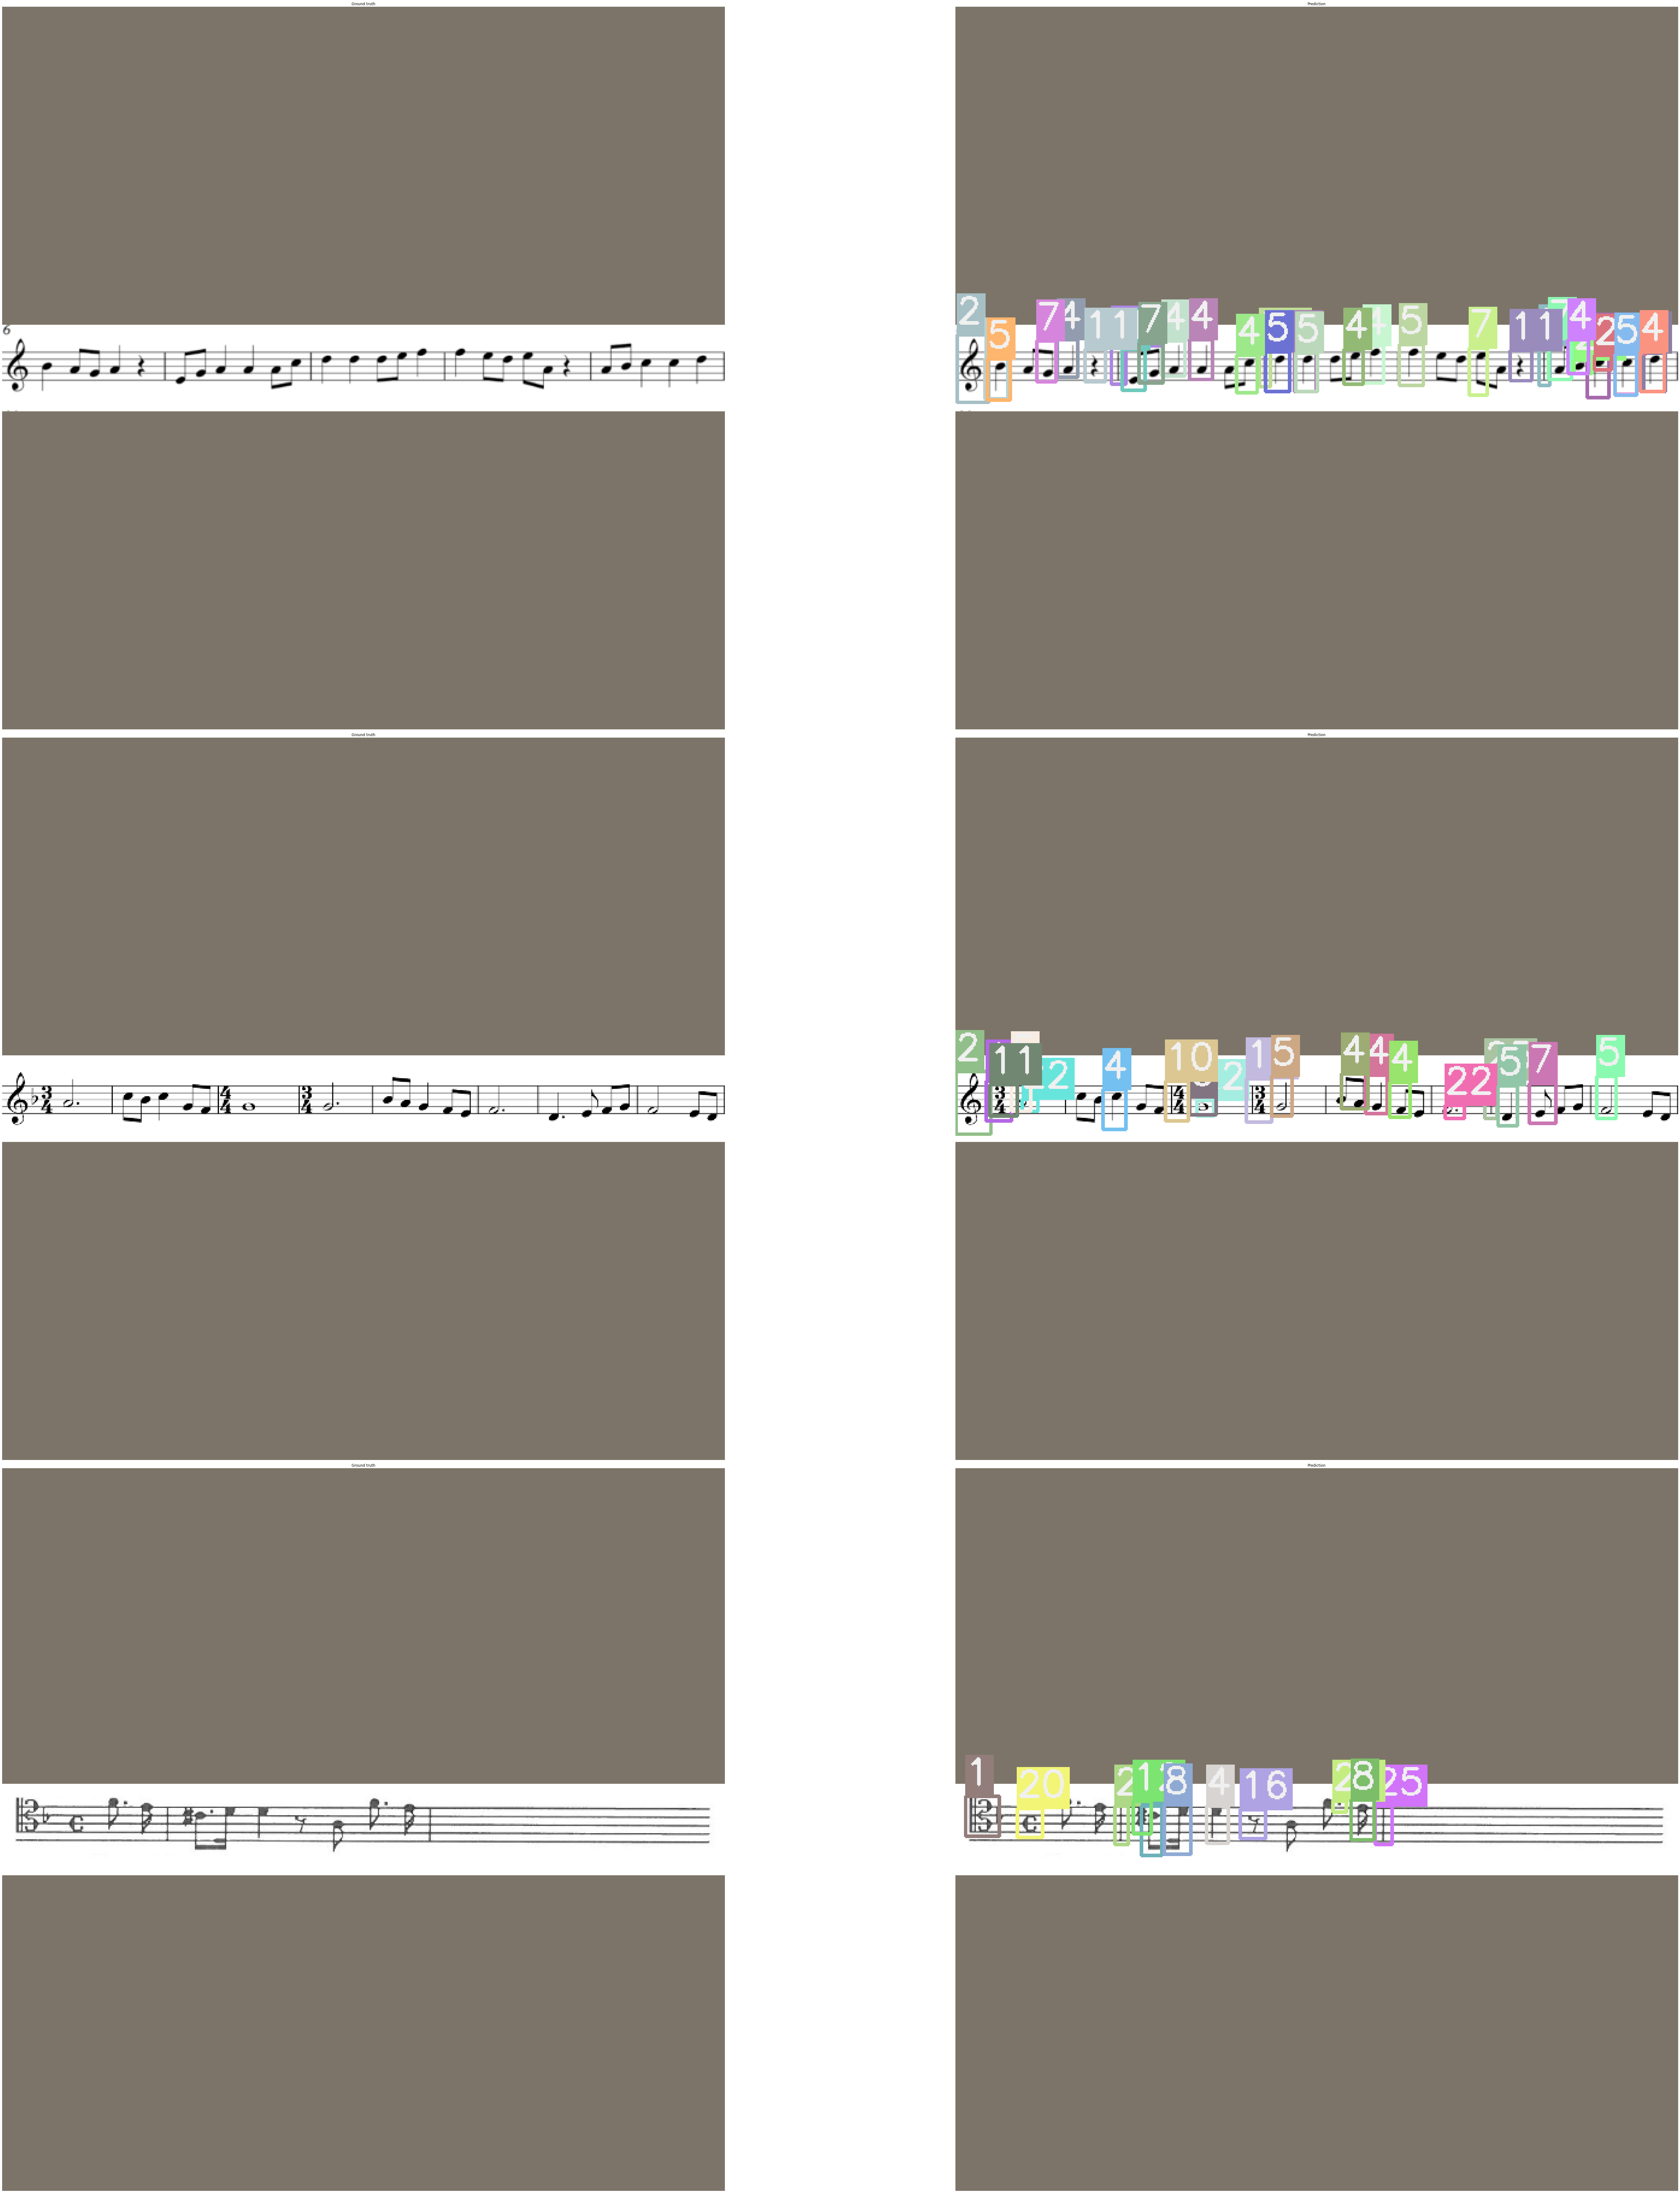

In [54]:
show_preds(samples=samples, preds=preds,denormalize_fn=denormalize_imagenet,figsize=(100,100))

# Modelo de clasificación de notas

In [55]:
%%capture
!pip install fastai --upgrade

In [1]:
from fastai.vision.all import *

In [5]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize((256,64)),
                 batch_tfms=aug_transforms(size=(256,64),mult=1.0, do_flip=True, flip_vert=False, max_rotate=5.0, min_zoom=1.0, max_zoom=1.05, max_lighting=0.1, max_warp=0.1, p_affine=0.3))

In [7]:
path = Path('notas/')

In [8]:
dls = db.dataloaders(path,bs=128)

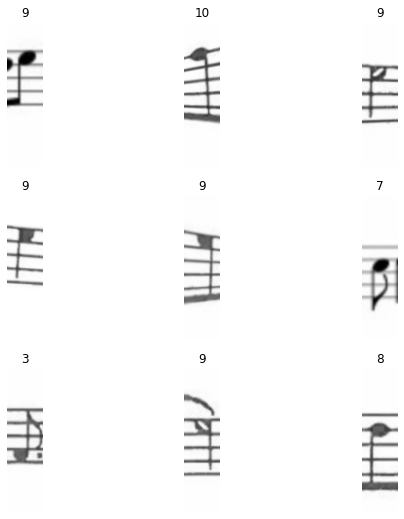

In [27]:
dls.show_batch()

In [10]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='modelResnet18')  
]

In [18]:
learn = cnn_learner(dls,arch=resnet18,metrics=accuracy,cbs=callbacks).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.010964781977236271)

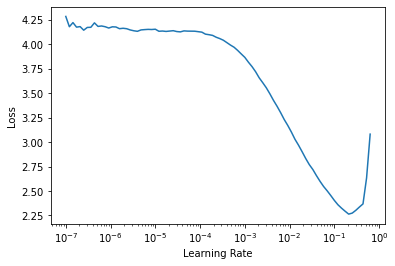

In [19]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.580043,8.195017,0.148936,00:02


Better model found at epoch 0 with valid_loss value: 8.195016860961914.


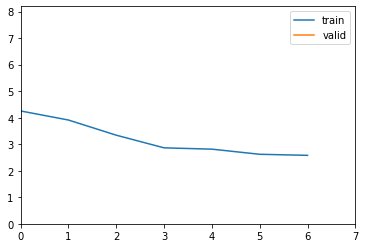

epoch,train_loss,valid_loss,accuracy,time
0,1.885193,4.474791,0.446809,00:02
1,1.385360,4.957617,0.497872,00:02
2,1.000508,1.364021,0.787234,00:02
3,0.770012,0.902240,0.753191,00:02
4,0.612581,0.907996,0.757447,00:02
5,0.502325,1.345349,0.634043,00:02
6,0.417486,1.313805,0.651064,00:02


Better model found at epoch 0 with valid_loss value: 4.474791049957275.


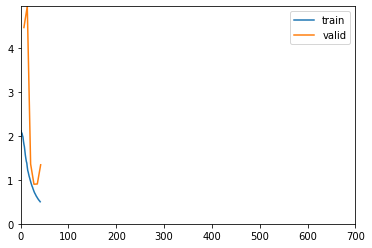

Better model found at epoch 2 with valid_loss value: 1.3640211820602417.
Better model found at epoch 3 with valid_loss value: 0.902239978313446.
No improvement since epoch 3: early stopping


In [20]:
learn.fine_tune(100, base_lr=10e-2)

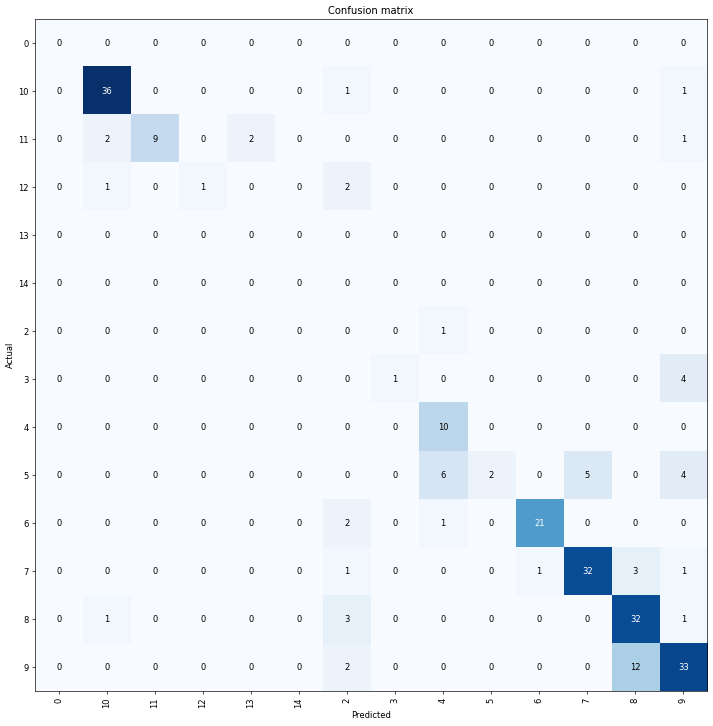

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

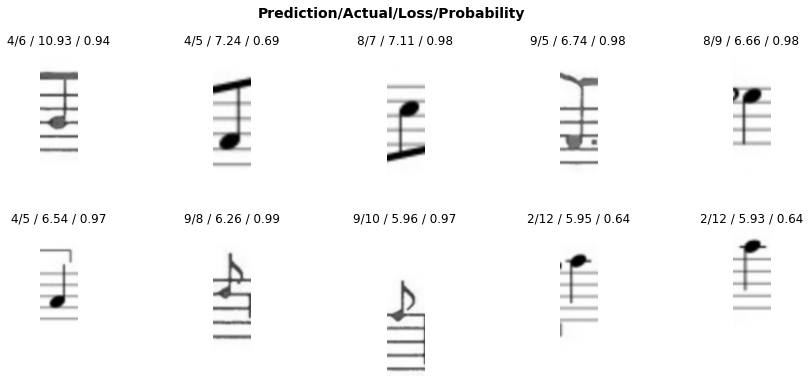

In [22]:
interp.plot_top_losses(10,nrows=2)

In [23]:
learn.export()